# <span style="color:Maroon">Short Term XgBoost Model

__Summary:__ <span style="color:Blue">In this code we shall build and test a short term XgBoost Model using Technical Indicators

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report
from sklearn import metrics
import os
import ta
import pickle
from scipy import interp
np.random.seed(0)

In [2]:
# User defined names
index = "SSE Composite"
filename = index+"_hurst_segment_dependent.csv"
date_col = "Date"

# Declare the hyper-parameters for grid search
max_depth = [4, 6]
min_child_weight = [10, 20]
gamma = [0, 0.1]
subsample = [0.8]
colsample_bytree = [0.8]
scale_pos_weight = [1]
learning_rate = [0.05, 0.1]
n_estimators = [200]
reg_alpha = [1e-5, 0.1, 1, 100]
reg_lambda = [0, 0.001, 0.01, 0.1]

In [3]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\sidhu\Downloads\Course 10 Capstone Project\Trading Strategy Development\Dev\SSE Composite\Codes


In [4]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [5]:
# Read the data
df = pd.read_csv(filename, index_col=date_col)
df.index = pd.to_datetime(df.index)
df.head()

,High,Low,Open,Close,Volume,Adj Close,hurst_100,hurst_150,hurst_200,hurst_250,...,Increasing days,Decreasing days,Zero Cross Neg,Zero Cross Pos,Zero Cross Total,Ratio Trend,Ratio Zero,Segment,DVT STD,Target
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,2855.395996,2810.107910,2825.329102,2852.647949,110000.0,2852.647949,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-05,2850.492920,2824.295898,2833.115967,2839.220947,104400.0,2839.220947,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-06,2853.875000,2816.950928,2838.435059,2824.197021,84800.0,2824.197021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-07,2868.004883,2807.870117,2820.665039,2838.801025,113200.0,2838.801025,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-10,2847.357910,2786.861084,2832.622070,2791.809082,90800.0,2791.809082,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0


## <span style="color:Maroon">Functions

In [6]:
def Split_data_XY(df, dv):
    """
    Given a dataset returns two dataframes, X-Dataframe and y-dataframe
    """
    X_df = df.drop([dv], axis=1)
    y_df = df[dv]
    y_labelizer = label_binarize(y_df, classes=[-1, 0, 1])
    return X_df, y_df, y_labelizer

In [7]:
def Get_Max_Discretevar(df, var, window=10):
    """
    Get maximum value on rolling basis for the variable
    """
    df[var+"_max"+str(window)] = df[var].rolling(window=window).max()
    return df

In [8]:
def Get_SMA_Continousvar(df, var, window=10):
    """
    Get SMA for continous variable
    """
    df[var+"_sma"+str(window)] = df[var].rolling(window=window).mean()
    return df

In [9]:
def Get_Ratio_Continousvar(df, var, window=10):
    """
    Get Ratio for continous variable Min/Max
    """
    df[var+"_ratio_minmax"+str(window)] = np.where(np.abs(df[var].rolling(window=window).max()) > 0, 
                                                   df[var].rolling(window=window).min()/
                                                   df[var].rolling(window=window).max(),0)
    return df

In [10]:
def Get_std_Continousvar(df, var, window=30):
    """
    Get Ratio for continous variable Min/Max
    """
    df[var+"_std"+str(window)] = df[var].rolling(window=window).std()
    return df

In [11]:
def Generate_Predicted_df(X_train, y_train, X_test, y_test, clf):
    """
    Generates Pandas dataframe with predicted values and other columns for P&L analysis
    """
    # Train Sample
    df_train = pd.DataFrame(y_train)
    df_train['Predicted'] = clf.predict(X_train)
    df_train['Adj Close'] = X_train['Adj Close']
    df_train['Open'] = X_train['Open']
    df_train['DVT STD'] = X_train['DVT STD']
    df_train["Sample"] = "Train"
    # Test Sample
    df_test = pd.DataFrame(y_test)
    df_test['Predicted'] = clf.predict(X_test)
    df_test['Adj Close'] = X_test['Adj Close']
    df_test['Open'] = X_test['Open']
    df_test['DVT STD'] = X_test['DVT STD']
    df_test['Sample'] = "Test"
    df = df_train.append(df_test)
    return df

## <span style="color:Maroon">Feature Engineering

In [12]:
# Add all technical features
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Adj Close", volume="Volume")

In [13]:
# Max variable list
max_vars = ['volatility_bbhi', 'volatility_bbli', 'volatility_kchi', 'volatility_kcli', 'trend_psar_up_indicator', 
            'trend_psar_down_indicator']
for i in range(0, len(max_vars)):
    df = Get_Max_Discretevar(df, max_vars[i], 10)

In [14]:
# SMA variable list
sma_vars = ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
            'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm', 'volatility_bbh', 
            'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 
            'volatility_kcw', 'volatility_kcp', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 
            'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 
            'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 
            'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 
            'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv', 
            'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 
            'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_stc', 
            'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
            'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
            'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr', 'others_dlr', 
            'others_cr']
for i in range(0, len(sma_vars)):
    df = Get_SMA_Continousvar(df, sma_vars[i], window=10)

In [15]:
# Ratio of Min Max variables
for i in range(0, len(sma_vars)):
    df = Get_Ratio_Continousvar(df, sma_vars[i], window=10)

In [16]:
# Ratio of std variables
for i in range(0, len(sma_vars)):
    df = Get_std_Continousvar(df, sma_vars[i], window=30)

In [17]:
# Drop two features
df = df.drop(['trend_psar_down', 'trend_psar_up'], axis=1)
df = df[df['hurst_150'] > 0]
df.shape

(2280, 341)

In [18]:
# Drop rows with null values
df.dropna(inplace=True)
df.shape

(2030, 341)

## <span style="color:Maroon">Divide the data in Segments

In [19]:
df['Segment'].value_counts()

Mean Reverting    1173
Trending           857
Name: Segment, dtype: int64

In [20]:
# Break dataset into three segments
df_MeanReverting = df[df['Segment'] == "Mean Reverting"]
df_Trending = df[df['Segment'] == "Trending"]

In [21]:
# Drop Segment variable from all datasets
df.drop("Segment", axis=1, inplace=True)
df_MeanReverting.drop("Segment", axis=1, inplace=True)
df_Trending.drop("Segment", axis=1, inplace=True)

#### <span style="color:Maroon">Mean Reverting Dataset

In [22]:
# Divide dataset into Train and Test Sample. (5 Fold CV will be used for validation)
df_MeanReverting_Train = df_MeanReverting[df_MeanReverting.index.year <= 2018]
df_MeanReverting_Test = df_MeanReverting[df_MeanReverting.index.year > 2018]
print("Train Sample: ", df_MeanReverting_Train.shape)
print("Test Sample: ", df_MeanReverting_Test.shape)

Train Sample:  (843, 340)
Test Sample:  (330, 340)


#### <span style="color:Maroon">Trending Dataset

In [23]:
df_Trending_Train = df_Trending[df_Trending.index.year <= 2018]
df_Trending_Test = df_Trending[df_Trending.index.year > 2018]
print("Train Sample: ", df_Trending_Train.shape)
print("Test Sample: ", df_Trending_Test.shape)

Train Sample:  (702, 340)
Test Sample:  (155, 340)


#### <span style="color:Maroon">Whole Dataset

In [24]:
df_Train = df[df.index.year <= 2018]
df_Test = df[df.index.year > 2018]
print("Train Sample: ", df_Train.shape)
print("Test Sample: ", df_Test.shape)

Train Sample:  (1545, 340)
Test Sample:  (485, 340)


## <span style="color:Maroon">XgBoost Model Grid Search

In [25]:
# Grid
grid = {'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': learning_rate,
        'n_estimators':n_estimators,
        'reg_alpha':reg_alpha,
        'reg_lambda':reg_lambda}

In [26]:
# XgBoost Model
scoring = {'Accuracy':make_scorer(balanced_accuracy_score)}
kfold = KFold(n_splits=3)
clf = XGBClassifier( objective= 'multi:softprob', num_classes=3, nthread=4, scale_pos_weight=1, seed=27, 
                    eval_metric='mlogloss')
# Define grid search
grid = GridSearchCV(estimator = clf, param_grid=grid, cv=kfold, scoring=scoring, refit='Accuracy', verbose=1, n_jobs=-1)

#### <span style="color:Maroon">Whole Dataset

In [27]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_Test, 'Target')

In [28]:
# Fit the grid search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 42.2min finished


[17:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [29]:
# Get the best xgboost model based on Grid Search
best_xgboost = model.best_estimator_
best_xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=0.1, reg_lambda=0.001,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [30]:
# XgBoost model selected using Grid search
clf = best_xgboost
clf.fit(X_train, y_train)

[17:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=0.1, reg_lambda=0.001,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [31]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [32]:
# Save the model
with open('whole_dataset'+str(index)+'_xgboost_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('whole_dataset'+str(index)+'_xgboost_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [33]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       262
           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00       477

    accuracy                           1.00      1545
   macro avg       1.00      1.00      1.00      1545
weighted avg       1.00      1.00      1.00      1545



In [34]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,259,3,0
0,0,805,1
1,0,0,477


In [35]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.23      0.18      0.20        66
           0       0.61      0.83      0.71       257
           1       0.62      0.31      0.42       162

    accuracy                           0.57       485
   macro avg       0.49      0.44      0.44       485
weighted avg       0.56      0.57      0.54       485



In [36]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,12,41,13
0,25,214,18
1,16,95,51


In [37]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [38]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

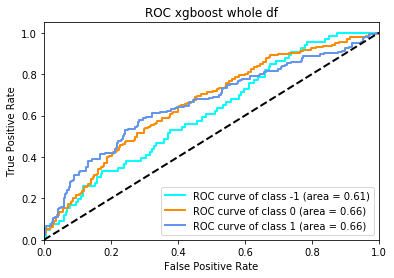

In [39]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC xgboost whole df')
plt.legend(loc="lower right")
plt.savefig("xgboost Whole df test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [40]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [41]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('whole_dataset'+str(index)+'_xgboost_model.csv', index=True)

#### <span style="color:Maroon">Trending Dataset

In [42]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_Trending_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_Trending_Test, 'Target')

In [43]:
# Fit the grid search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 12.8min finished


[17:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [44]:
# Get the best xgboost model based on Grid Search
best_xgboost = model.best_estimator_
best_xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=0.1, reg_lambda=0.1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [45]:
# XgBoost model selected using Grid search
clf = best_xgboost
clf.fit(X_train, y_train)

[17:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=0.1, reg_lambda=0.1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [46]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [47]:
# Save the model
with open('Trending_dataset'+str(index)+'_xgboost_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('Trending_dataset'+str(index)+'_xgboost_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [48]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       134
           0       0.99      0.99      0.99       363
           1       1.00      1.00      1.00       205

    accuracy                           0.99       702
   macro avg       0.99      0.99      0.99       702
weighted avg       0.99      0.99      0.99       702



In [49]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,133,1,0
0,1,361,1
1,0,1,204


In [50]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.24      0.44      0.31        18
           0       0.65      0.67      0.66        83
           1       0.51      0.33      0.40        54

    accuracy                           0.53       155
   macro avg       0.47      0.48      0.46       155
weighted avg       0.56      0.53      0.53       155



In [51]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,8,6,4
0,14,56,13
1,12,24,18


In [52]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [53]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

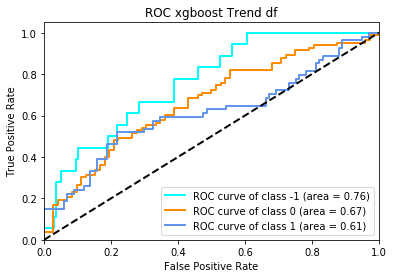

In [54]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC xgboost Trend df')
plt.legend(loc="lower right")
plt.savefig("xgboost Trending_dataset test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [55]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [56]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('Trending_dataset'+str(index)+'_xgboost_model.csv', index=True)

#### <span style="color:Maroon">Mean Reverting Dataset

In [57]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_MeanReverting_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_MeanReverting_Test, 'Target')

In [58]:
# Fit the grid search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 17.3min finished


[18:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [59]:
# Get the best xgboost model based on Grid Search
best_xgboost = model.best_estimator_
best_xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=1, reg_lambda=0.001,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [60]:
# XgBoost model selected using Grid search
clf = best_xgboost
clf.fit(X_train, y_train)

[18:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_classes, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_classes=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=1, reg_lambda=0.001,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=True, ...)

In [61]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [62]:
# Save the model
with open('MeanReverting_dataset'+str(index)+'_xgboost_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('MeanReverting_dataset'+str(index)+'_xgboost_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [63]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       128
           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00       272

    accuracy                           1.00       843
   macro avg       1.00      1.00      1.00       843
weighted avg       1.00      1.00      1.00       843



In [64]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,128,0,0
0,0,443,0
1,0,0,272


In [65]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.67      0.04      0.08        48
           0       0.57      0.91      0.70       174
           1       0.53      0.24      0.33       108

    accuracy                           0.57       330
   macro avg       0.59      0.40      0.37       330
weighted avg       0.57      0.57      0.49       330



In [66]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,2,37,9
0,1,159,14
1,0,82,26


In [67]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [68]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

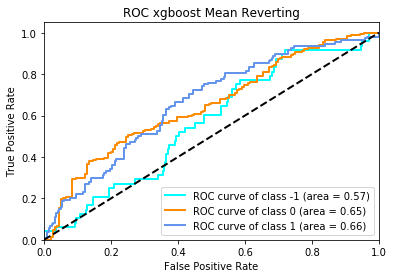

In [69]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC xgboost Mean Reverting')
plt.legend(loc="lower right")
plt.savefig("xgboost MeanReverting_dataset test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [70]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [71]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('MeanReverting_dataset'+str(index)+'_xgboost_model.csv', index=True)